In [1]:
import os
import subprocess

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_graphviz 


from sklearn import tree
from pandas import read_table, DataFrame
from os import system

In [2]:
df = pd.read_csv('train.csv')

In [ ]:
print("* df.head()", df.head(), sep="\n", end="\n\n")
print("* df.tail()", df.tail(), sep="\n", end="\n\n")
list(df)

In [ ]:
#goal: to predict outcome (adoption, return to owner, euthanasia, diead) given the features SexuponOutcome, AgeuponOutcome, Breed and Color. 
#We can use pandas to show the adoption types:
print("* outcome types:", df["OutcomeType"].unique())

In [3]:
def encode_target(df, target_column):
    df_mod = df.copy()
    targets = df_mod[target_column].unique()
    map_to_int = {name: n for n, name in enumerate(targets)}
    df_mod["Target"] = df_mod[target_column].replace(map_to_int)

    return (df_mod, targets)

In [4]:
def get_sex(x):
    x=str(x)
    if x.find('Male') >= 0: return 'male'
    if x.find('Female') >= 0: return 'female'
    return 'unknown'
def get_neutered(x):
    x=str(x)
    if x.find('Spayed') >= 0: return 'neutered'
    if x.find('Neutered') >= 0: return 'neutered'
    if x.find('Intact') >= 0: return 'intact'
    return 'unknown'

In [5]:
df['Sex']=df.SexuponOutcome.apply(get_sex)
df['Neutered']= df.SexuponOutcome.apply(get_neutered)

In [6]:
#looking at csv file, if 'Mix' in the desc then assume not purebred. ex.American Pit Bull Terrier Mix
def get_mix(x):
    x = str(x)
    if x.find('Mix')>= 0: return 'mix'
    return 'not'

In [7]:
def calc_age_in_years(x):
    x=str(x)
    if x == 'nan': return 0
    age = int(x.split()[0])
    if x.find('year')> -1: return age
    if x.find('month')> -1: return age/12.
    if x.find('week')> -1: return age/52.
    if x.find('day')> -1: return age/365.
    else: return 0

In [8]:
df['AgeInYears'] = df.AgeuponOutcome.apply(calc_age_in_years)

In [9]:
def calc_age_category(x):
    if x < 3: return 'young'
    if x < 5: return 'young adult'
    if x < 10: return 'adult'
    return 'old'

In [10]:
df['Mix']= df.Breed.apply(get_mix)
df['AgeCategory']=df.AgeInYears.apply(calc_age_category)

In [12]:
#list(df)

In [11]:
sex_dummies = pd.get_dummies(df['Sex'])
age_group_dummies = pd.get_dummies(df['AgeCategory'])
mix_dummies = pd.get_dummies(df['Mix'])
neutered_dummies = pd.get_dummies(df['SexuponOutcome'])

In [12]:
df3= pd.concat([sex_dummies, age_group_dummies, mix_dummies, neutered_dummies], axis=1)

In [13]:
df3.head()

,female,male,unknown,adult,old,young,young adult,mix,not,Intact Female,Intact Male,Neutered Male,Spayed Female,Unknown
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [14]:
list(df)

['AnimalID',
 'Name',
 'DateTime',
 'OutcomeType',
 'OutcomeSubtype',
 'AnimalType',
 'SexuponOutcome',
 'AgeuponOutcome',
 'Breed',
 'Color',
 'Sex',
 'Neutered',
 'AgeInYears',
 'Mix',
 'AgeCategory']

In [17]:
#encode the target variable from the original df which is just the training csv from kaggle
df2, targets = encode_target(df, "OutcomeType")

In [18]:
df2[["Target", "OutcomeType"]].head()

,Target,OutcomeType
0,0,Return_to_owner
1,1,Euthanasia
2,2,Adoption
3,3,Transfer
4,3,Transfer


In [ ]:
df2.head()

In [19]:
df2["Target"].unique()

array([0, 1, 2, 3, 4], dtype=int64)

In [20]:
#return to owner = 0, euthanasia =1, adoption =2, transfer =3, died = 4

In [22]:
df_join = df2.join(df3)

In [23]:
list(df_join)

['AnimalID',
 'Name',
 'DateTime',
 'OutcomeType',
 'OutcomeSubtype',
 'AnimalType',
 'SexuponOutcome',
 'AgeuponOutcome',
 'Breed',
 'Color',
 'Sex',
 'Neutered',
 'AgeInYears',
 'Mix',
 'AgeCategory',
 'Target',
 'female',
 'male',
 'unknown',
 'adult',
 'old',
 'young',
 'young adult',
 'mix',
 'not',
 'Intact Female',
 'Intact Male',
 'Neutered Male',
 'Spayed Female',
 'Unknown']

In [25]:
features = list(df_join.columns[16:30])
features

['female',
 'male',
 'unknown',
 'adult',
 'old',
 'young',
 'young adult',
 'mix',
 'not',
 'Intact Female',
 'Intact Male',
 'Neutered Male',
 'Spayed Female',
 'Unknown']

In [26]:
y = df_join["Target"]
X = df_join[features]
dt = DecisionTreeClassifier(min_samples_split=20, random_state=99)
dt.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            presort=False, random_state=99, splitter='best')

In [27]:
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

In [28]:
%matplotlib inline
visualize_tree(dt, features)

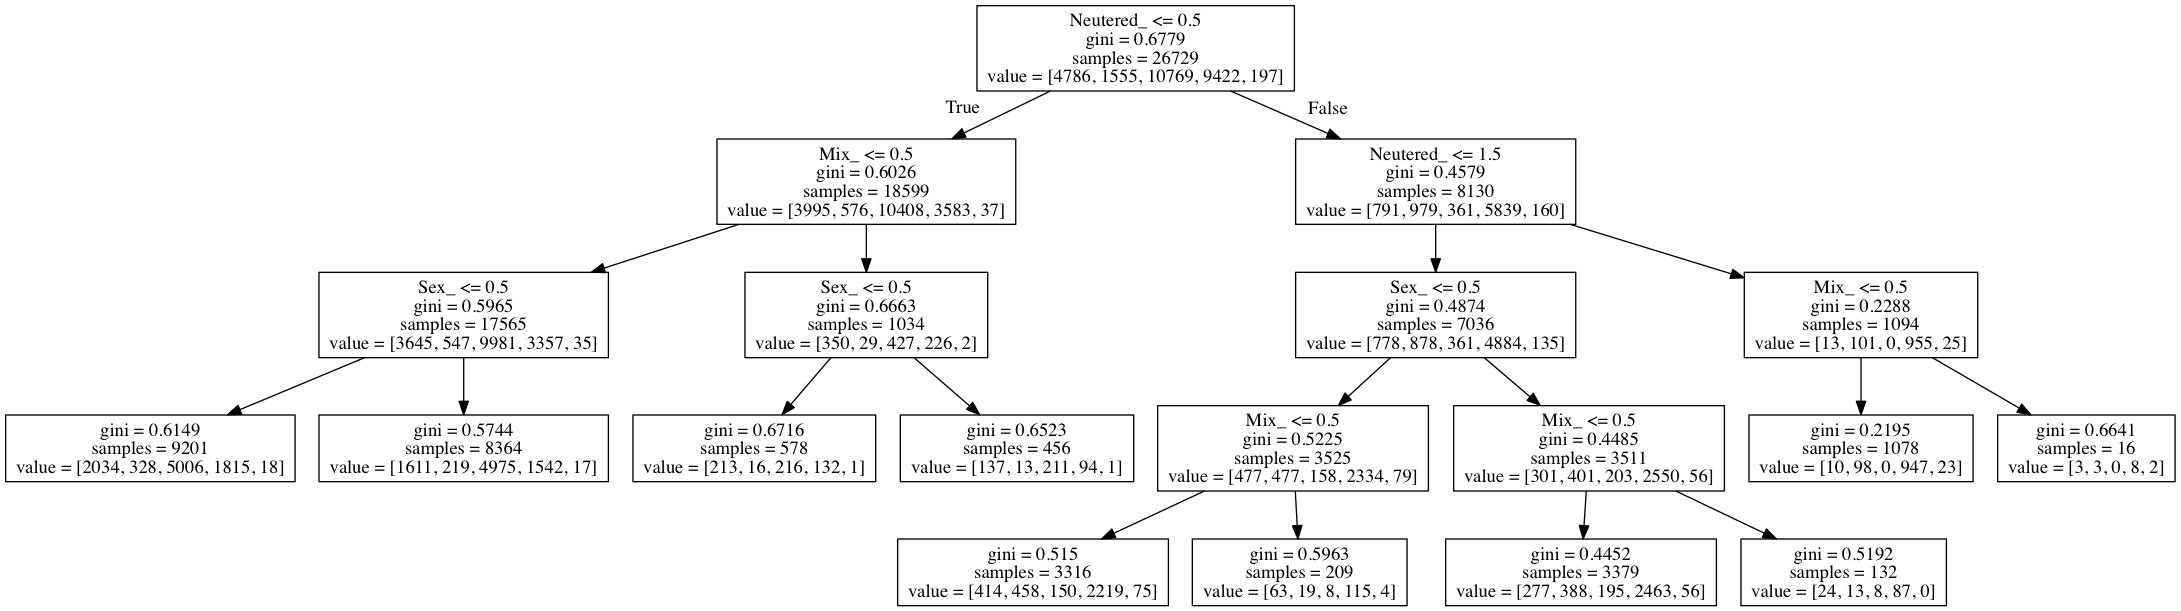

In [29]:
from IPython.display import Image
Image("dt.png", unconfined=False)

In [30]:
# PRINT OUT VARIABLE IMPORTANCE
print(DataFrame(dt.feature_importances_, columns = ["Imp"], index = X.columns).sort_values(['Imp'], ascending = False))

                    Imp
Intact Male    0.306957
Intact Female  0.257944
young          0.210222
Unknown        0.200231
old            0.006327
young adult    0.006193
mix            0.003844
female         0.003783
not            0.002366
adult          0.001271
male           0.000576
Spayed Female  0.000194
Neutered Male  0.000092
unknown        0.000000


In [94]:
df_test = pd.read_csv('test.csv')

In [95]:
df_test.head(2)

,ID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,1,Summer,10/12/2015 12:15,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White
1,2,Cheyenne,7/26/2014 17:59,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan


In [96]:
df_test['Sex']=df_test.SexuponOutcome.apply(get_sex)
df_test['Neutered']= df_test.SexuponOutcome.apply(get_neutered)
df_test['AgeInYears'] = df_test.AgeuponOutcome.apply(calc_age_in_years)
df_test['Mix']= df_test.Breed.apply(get_mix)
df_test['AgeCategory']=df_test.AgeInYears.apply(calc_age_category)

In [97]:
sex_dummies2 = pd.get_dummies(df_test['Sex'])
age_group_dummies2 = pd.get_dummies(df_test['AgeCategory'])
mix_dummies2 = pd.get_dummies(df_test['Mix'])
neutered_dummies2 = pd.get_dummies(df_test['SexuponOutcome'])

In [98]:
df4= pd.concat([sex_dummies2, age_group_dummies2, mix_dummies2, neutered_dummies2], axis=1)
df4.head()
#dummies = pd.get_dummies(df['Category']).rename(columns=lambda x: 'Category_' + str(x))
#df_test = pd.concat([df_test, df4], axis=1)
#df = df.drop(['Category'], inplace=True, axis=1)

,female,male,unknown,adult,old,young,young adult,mix,not,Intact Female,Intact Male,Neutered Male,Spayed Female,Unknown
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [99]:
len(df4)

11456

In [100]:
len(df_test)

11456

In [72]:
#df4 = df4.join(df_test['ID'])

In [101]:
df4.head()

,female,male,unknown,adult,old,young,young adult,mix,not,Intact Female,Intact Male,Neutered Male,Spayed Female,Unknown
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [74]:
#df4 should be only the columns needed for the model decision tree

In [102]:
dt.predict(df4)

array([3, 2, 2, ..., 3, 0, 3], dtype=int64)

In [103]:
dt.predict_proba(df4)

array([[ 0.05555556,  0.08625731,  0.0621345 ,  0.77850877,  0.01754386],
       [ 0.13346614,  0.00896414,  0.67729084,  0.18027888,  0.        ],
       [ 0.14640572,  0.01637185,  0.63963116,  0.19665036,  0.00094091],
       ..., 
       [ 0.05555556,  0.08625731,  0.0621345 ,  0.77850877,  0.01754386],
       [ 0.37557817,  0.05920444,  0.33857539,  0.22571693,  0.00092507],
       [ 0.30769231,  0.19230769,  0.        ,  0.5       ,  0.        ]])

In [104]:
pd.DataFrame({"outcome": y_pred}).to_csv('submission_try1.csv',index=False)

In [ ]:
#IGNORE ALL OF THIS#

In [75]:
#from sklearn.ensemble import RandomForestRegressor, BaggingRegressor

In [77]:
#y_train = df_join["Target"]
#X_train = df_join[features]
#X_test = df4

In [105]:
#rf = RandomForestRegressor(n_estimators=15, max_depth=6, random_state=0)
#clf = BaggingRegressor(rf, n_estimators=45, max_samples=0.1, random_state=25)
#clf.fit(X_train, y_train)
#y_pred = clf.predict(X_test)

In [106]:
#print(y_pred)


In [107]:
#rf.feature_importances_

In [ ]:
#pd.DataFrame({"id": id_test, "relevance": y_pred}).to_csv('submission.csv',index=False)